In [1]:
import numpy as np
import matplotlib.pyplot as plt
from healpix_geo.coordinates import latitude_authalic_to_geographic, latitude_geographic_to_authalic

In [2]:
sphere_lat = np.linspace(0, np.pi/2, int(1e6)) # range of spherical latitudes in radians used for area distortion evaluation
sphere_lat

array([0.00000000e+00, 1.57079790e-06, 3.14159580e-06, ...,
       1.57079319e+00, 1.57079476e+00, 1.57079633e+00], shape=(1000000,))

In [3]:
# lazy identity mapping expressed in ellipsoidal geographic latitudes
lazy_mapped_lat_in_geographic_coords = np.copy(sphere_lat) 

# authalic mapping expressed in ellipsoidal geographic latitudes
authalic_mapped_lat_in_geographic_coords = np.deg2rad(latitude_authalic_to_geographic(sphere_lat, "WGS84"))

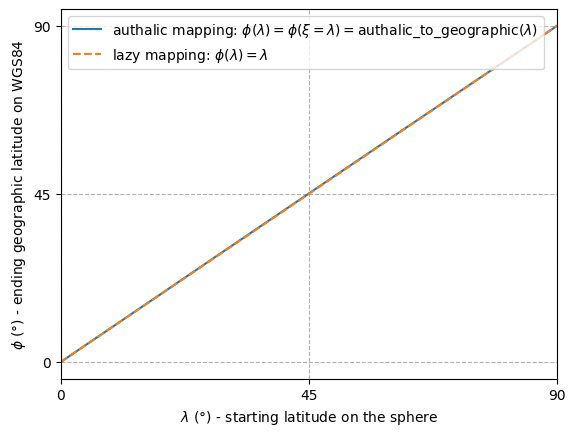

In [4]:
plt.plot(np.rad2deg(sphere_lat), np.rad2deg(authalic_mapped_lat_in_geographic_coords), label=r'authalic mapping: $\phi(\lambda)=\phi(\xi=\lambda)=$authalic_to_geographic$(\lambda)$')
plt.plot(np.rad2deg(sphere_lat), np.rad2deg(lazy_mapped_lat_in_geographic_coords), label=r'lazy mapping: $\phi(\lambda)=\lambda$', ls='--')
plt.legend(loc='upper left')
plt.xlabel(r"$\lambda$ (°) - starting latitude on the sphere")
plt.ylabel(r"$\phi$ (°) - ending geographic latitude on WGS84")
plt.xlim(0, 90)
plt.xticks([0, 45, 90])
plt.yticks([0, 45, 90])
plt.grid(True, ls='--')
plt.show()

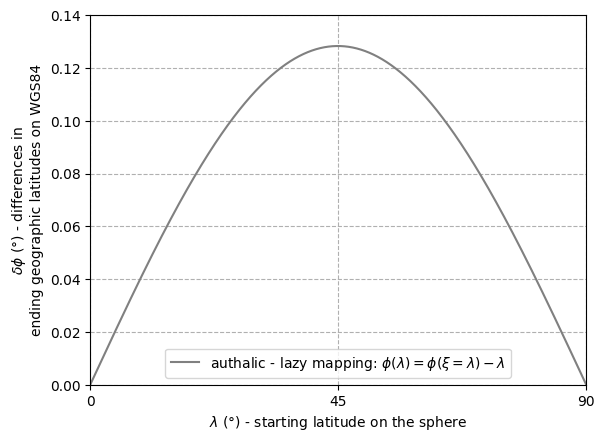

In [5]:
plt.plot(np.rad2deg(sphere_lat), 
         np.rad2deg(authalic_mapped_lat_in_geographic_coords) - np.rad2deg(lazy_mapped_lat_in_geographic_coords), 
         label=r'authalic - lazy mapping: $\phi(\lambda)=\phi(\xi=\lambda)-\lambda$', c='gray')
plt.legend(loc='lower center')
plt.xlabel(r"$\lambda$ (°) - starting latitude on the sphere")
plt.ylabel(r"$\delta \phi$"+" (°) - differences in\nending geographic latitudes on WGS84")
plt.xlim(0, 90)
plt.ylim(0, .14)
plt.xticks([0, 45, 90])
plt.grid(True, ls='--')
plt.show()

In [6]:
# WGS84 values
a = 6378137.0
b = 6356752.314245179497563967


def f(a,b):
    return (a-b)/a

def e(a,b):
    return np.sqrt((a**2 - b**2)/a**2)

def q(phi, e):
    return (1-e**2) * np.sin(phi) / (1-e**2 * np.sin(phi)**2) - np.log((1-e*np.sin(phi))/(1+e*np.sin(phi))) * (1-e**2) / (2*e)

authalic_radius = a * np.sqrt(q(np.pi/2, e(a,b)) / 2)


def geographic_to_parametric(phi, f):
    return np.atan((1-f)*np.tan(phi))

def geographic_to_xz(phi, a, b):
    beta = geographic_to_parametric(phi, f(a,b))
    return np.array([a * np.cos(beta), b * np.sin(beta)])

def infinitesimal_arc_length(phi, a, b):
    return np.sqrt(np.sum(np.diff(geographic_to_xz(phi, a, b), axis=-1)**2, axis=0))

def parallel_radius(phi, a, b):
    return a * np.abs(np.cos(geographic_to_parametric(phi, f(a, b)))) # m

def infinitesimal_cell_area(phi, a, b):
    return infinitesimal_arc_length(phi, a, b) * parallel_radius(phi[:-1], a, b)

def local_area_stretch(initial_sphere_lat, phi, a, b):
    return infinitesimal_cell_area(phi, a, b) / infinitesimal_cell_area(initial_sphere_lat, authalic_radius, authalic_radius)

/var/folders/fn/x6crbtrd08b_gtsnsyrybdfc0000gp/T/ipykernel_39922/2956062897.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels([f'{x:.1%}' for x in plt.gca().get_yticks()])


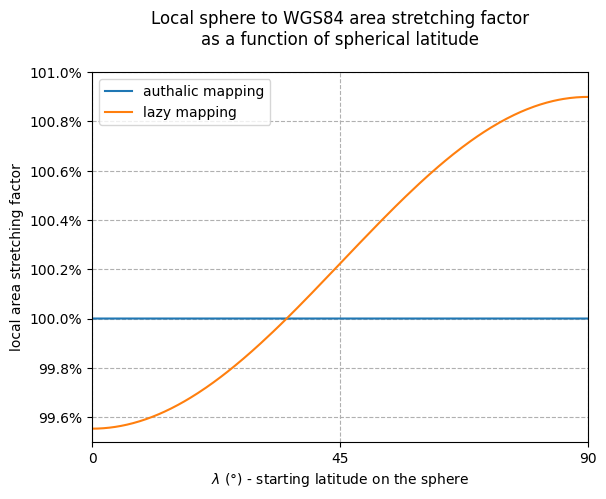

In [7]:
plt.plot(np.rad2deg(sphere_lat)[:-1], 
         local_area_stretch(sphere_lat, authalic_mapped_lat_in_geographic_coords, a, b),
         label='authalic mapping')
plt.plot(np.rad2deg(sphere_lat)[:-1], 
         local_area_stretch(sphere_lat, lazy_mapped_lat_in_geographic_coords, a, b),
         label='lazy mapping')
plt.gca().set_yticklabels([f'{x:.1%}' for x in plt.gca().get_yticks()]) 
plt.legend()
plt.xticks([0, 45, 90])
plt.grid(True, ls='--')
plt.xlim(0, 90)
plt.ylim(0.995, 1.01)
plt.title("Local sphere to WGS84 area stretching factor\nas a function of spherical latitude", pad=20)
plt.xlabel(r"$\lambda$ (°) - starting latitude on the sphere")
plt.ylabel("local area stretching factor")
plt.show()

In [8]:
# even if there are local area distrotions, check that total areas are conserved
np.sum(infinitesimal_cell_area(lazy_mapped_lat_in_geographic_coords, a, b)) / \
np.sum(infinitesimal_cell_area(sphere_lat, authalic_radius, authalic_radius)) - 1

np.float64(1.7659640416667344e-09)

In [9]:
# even if there are local area distrotions, check that total areas are conserved
np.sum(infinitesimal_cell_area(authalic_mapped_lat_in_geographic_coords, a, b)) / \
np.sum(infinitesimal_cell_area(sphere_lat, authalic_radius, authalic_radius)) - 1

np.float64(5.860780749600281e-10)